# Fashion MNIST using a custom training loop
we will build a custom training loop and a validation loop to traing a model on the Fashion mnist ds

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/2-custom_and_distributed_training/week-2/C2_W2_Lab_2_training-categorical.ipynb

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker
import pdb

In [24]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, download=True)

test_data = tfds.load("fashion_mnist", split = "test", download=True)

class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


In [25]:
train_data

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [26]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [27]:
batch_size = 64
train_data = train_data.shuffle(buffer_size=1024).batch(batch_size)

# test_data =  test_data.batch(batch_size=batch_size)

train_data

<BatchDataset shapes: ((None, 784), (None,)), types: (tf.float32, tf.int64)>

In [28]:
def base_model():
    flattened_image_dim = 28*28
    inputs = tf.keras.layers.Input(shape=(flattened_image_dim, ), name="flat_input")
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
    output = tf.keras.layers.Dense(10, activation='softmax', name='prediction')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=output)

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()


# these metrics show us stats for every epoch, we have to gather data during training and validation in the epoch, and at the end show the metrics.
#  Before the next epoch we need to clear the metrics for the next epoch training
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


### Building Training Loop
In this section you build your training loop consisting of training and validation sequences.

The core of training is using the model to calculate the current_prediction on specific set of inputs and compute loss (in this case sparse categorical crossentropy) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [9]:
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        current_prediction = model(x)
        loss_val =loss_obj(y_true=y, y_pred= current_prediction)
        # every layer has x trainable parameters and we find the derivative of the loss with respect to each of those trainable weights

        
    gradients = tape.gradient(loss_val, model.trainable_weights)
    # # every neuron has a weight and a bias so 2 parameters,
    # but when we do the gradient we get two seprate arrays, so the zip() puts them together so the first item
    # in the w gradient and the first item in the b gradient will be zipped together and be applied to be the first model's new trainable param
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) 

    return current_prediction, loss_val

In [30]:
train_data

<BatchDataset shapes: ((None, 784), (None,)), types: (tf.float32, tf.int64)>

In [11]:
# one epoch means that we ran through ALL of the batches and saw all the training data and adjusted the weights based on that,
# and we use `update_state` to update the metrics 


def train_data_for_one_epoch():
    losses = []
    total_num = len(list(enumerate(train_data)))
    progress_bar=tqdm(total=total_num,position=0,leave=True,bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(train_data):
        # pdb.set_trace()
        # print(x_batch_train.shape)
        prediction, loss_val = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
        losses.append(loss_val)
        train_acc_metric(y_batch_train, prediction)

        progress_bar.set_description("Training loss for step %s: %.4f " % (int(step), float(loss_val)) )
        progress_bar.update()

    return losses
    


def perform_validation():
    lossess = []
    for x_val, y_val in test_data:
        pred = model(x_val)
        loss = loss_obj(y_true = y_val, y_pred=pred)
        lossess.append(loss)
        val_acc_metric(y_val, pred)
    return lossess

In [12]:
model = base_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flat_input (InputLayer)      [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
prediction (Dense)           (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

In [22]:
epochs = 10
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print("Starting epoch %d"%epoch)

    losses_train = train_data_for_one_epoch()
    train_acc = train_acc_metric.result()

    losses_val = perform_validation()
    val_acc = val_acc_metric.result()
    
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_train_losses.append(losses_train_mean)
    epochs_val_losses.append(losses_val_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Starting epoch 0


Training loss for step 937: 0.3374 : 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.2477  Validation Loss: 0.3409, Train Accuracy: 0.9079, Validation Accuracy 0.8823
Starting epoch 1


Training loss for step 937: 0.1097 : 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.2430  Validation Loss: 0.3619, Train Accuracy: 0.9096, Validation Accuracy 0.8782
Starting epoch 2


Training loss for step 937: 0.3931 : 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.2344  Validation Loss: 0.3596, Train Accuracy: 0.9123, Validation Accuracy 0.8791
Starting epoch 3


Training loss for step 937: 0.0887 : 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.2289  Validation Loss: 0.3583, Train Accuracy: 0.9139, Validation Accuracy 0.8810
Starting epoch 4


Training loss for step 937: 0.1314 : 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.2228  Validation Loss: 0.3647, Train Accuracy: 0.9149, Validation Accuracy 0.8790
Starting epoch 5


Training loss for step 937: 0.1220 : 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.2185  Validation Loss: 0.3731, Train Accuracy: 0.9175, Validation Accuracy 0.8787
Starting epoch 6


Training loss for step 937: 0.1959 : 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.2136  Validation Loss: 0.3910, Train Accuracy: 0.9192, Validation Accuracy 0.8753
Starting epoch 7


Training loss for step 937: 0.0800 : 100%|██████████| 938/938 



 Epoch 7: Train loss: 0.2079  Validation Loss: 0.3766, Train Accuracy: 0.9205, Validation Accuracy 0.8787
Starting epoch 8


Training loss for step 937: 0.1153 : 100%|██████████| 938/938 



 Epoch 8: Train loss: 0.2055  Validation Loss: 0.3752, Train Accuracy: 0.9227, Validation Accuracy 0.8802
Starting epoch 9


Training loss for step 937: 0.1096 : 100%|██████████| 938/938 



 Epoch 9: Train loss: 0.1992  Validation Loss: 0.3788, Train Accuracy: 0.9251, Validation Accuracy 0.8826


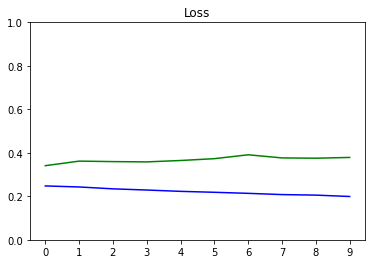

In [31]:
# evaluate the model

def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    # mticker.MultipleLocator(1) sets a tick for every x integer,so if x=1 distance between each tick is 1
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label= metric_name)
    plt.plot(val_metric,color='green', label='val_' + metric_name)
plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)


0.25678417

In [17]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)


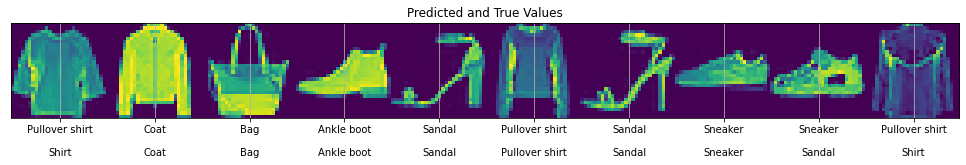

In [32]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)

In [ ]:
# it is prediction \n \n Label